### Compaison du modele avec et sans energy stare score
Au vue de nos metriques nous deduisons que l'impact de l'energy stare score pour notre modéle est négligeable au vue des coûts nécéssaire au calcul de ce score.


## Feature importance et interprétabilité du meilleur modéle
Vue que le deadline est proche nous ne pouvons pas nous lancer pour le feature importance du meilleur modéle.Toute fois notons que dans le notebook_06 à la fin nous avons procéder a une analyse des feature importance.le meilleur modéle dans ce notebook est similaire au meilleur modéle aprés experimentation Mlflow.

In [3]:
import sys
from pathlib import Path

# Racine projet
PROJECT_ROOT = Path("../").resolve()  # remonte d’un niveau depuis notebooks/
SRC_PATH = PROJECT_ROOT / "src"

if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

# Vérifier
print(sys.path)


['C:\\Users\\HP\\Desktop\\temp\\TODO\\SEMESTRE_1\\ML1\\ML-prediction-CO2\\src', 'C:\\Users\\HP\\Desktop\\temp\\TODO\\SEMESTRE_1\\ML1\\src', 'C:\\Users\\HP\\AppData\\Local\\Programs\\Python\\Python312\\python312.zip', 'C:\\Users\\HP\\AppData\\Local\\Programs\\Python\\Python312\\DLLs', 'C:\\Users\\HP\\AppData\\Local\\Programs\\Python\\Python312\\Lib', 'C:\\Users\\HP\\AppData\\Local\\Programs\\Python\\Python312', 'c:\\Users\\HP\\Desktop\\temp\\TODO\\SEMESTRE_1\\ML1\\ML-prediction-CO2\\env', '', 'c:\\Users\\HP\\Desktop\\temp\\TODO\\SEMESTRE_1\\ML1\\ML-prediction-CO2\\env\\Lib\\site-packages', 'c:\\Users\\HP\\Desktop\\temp\\TODO\\SEMESTRE_1\\ML1\\ML-prediction-CO2\\env\\Lib\\site-packages\\win32', 'c:\\Users\\HP\\Desktop\\temp\\TODO\\SEMESTRE_1\\ML1\\ML-prediction-CO2\\env\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\HP\\Desktop\\temp\\TODO\\SEMESTRE_1\\ML1\\ML-prediction-CO2\\env\\Lib\\site-packages\\Pythonwin']


In [4]:
from models.transformer import GroupMedianImputer, GroupModeImputer


In [8]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Charger pipeline
pipeline = joblib.load("../best_model/seattle_energy_2016_ml/best_model_ridge.joblib")

preprocessor = pipeline.named_steps["preprocessor"]
model = pipeline.named_steps["model"]


In [11]:
def get_feature_names_from_column_transformer(ct):
    feature_names = []

    for name, transformer, columns in ct.transformers_:
        if transformer == "drop":
            continue

        # Cas Pipeline (imputer + scaler / encoder)
        if hasattr(transformer, "steps"):
            last_step = transformer.steps[-1][1]
        else:
            last_step = transformer

        # OneHotEncoder
        if hasattr(last_step, "get_feature_names_out"):
            names = last_step.get_feature_names_out()
            feature_names.extend(names)

        # Numérique (scaler, passthrough, etc.)
        else:
            if isinstance(columns, (list, tuple)):
                feature_names.extend(columns)
            else:
                feature_names.append(columns)

    return feature_names


In [12]:
feature_names = get_feature_names_from_column_transformer(preprocessor)
coefs = model.coef_

assert len(feature_names) == len(coefs)

importance_df = (
    pd.DataFrame({
        "feature": feature_names,
        "coefficient": coefs,
        "abs_coefficient": np.abs(coefs)
    })
    .sort_values("abs_coefficient", ascending=False)
)

display(importance_df.head(20))


,feature,coefficient,abs_coefficient
16,PrimaryPropertyType_Laboratory,1.492018,1.492018
58,Has_Gas,1.212173,1.212173
24,PrimaryPropertyType_Self-Storage Facility,-1.190434,1.190434
22,PrimaryPropertyType_Restaurant,1.112782,1.112782
12,PrimaryPropertyType_Distribution Center,-1.032512,1.032512
59,Has_Steam,1.030673,1.030673
28,PrimaryPropertyType_Warehouse,-0.947757,0.947757
13,PrimaryPropertyType_Hospital,0.934366,0.934366
26,PrimaryPropertyType_Supermarket / Grocery Store,0.916663,0.916663
7,log_GFA,0.883005,0.883005


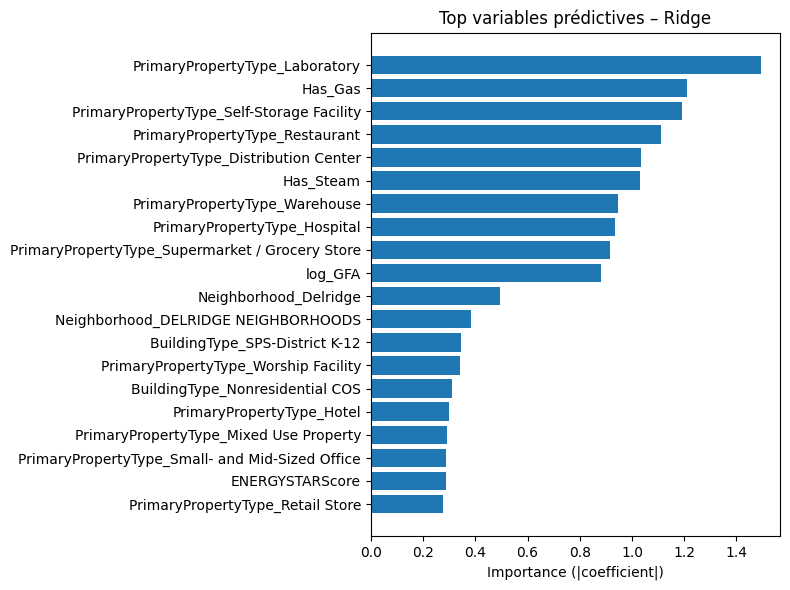

In [13]:
top = importance_df.head(20).iloc[::-1]

plt.figure(figsize=(8, 6))
plt.barh(top["feature"], top["abs_coefficient"])
plt.xlabel("Importance (|coefficient|)")
plt.title("Top variables prédictives – Ridge")
plt.tight_layout()
plt.show()


raw_feature
PrimaryPropertyType    9.828703
Neighborhood           2.685164
Has                    2.358928
log                    0.883005
BuildingType           0.754862
ENERGYSTARScore        0.286176
IsMixedUse             0.132273
Parking                0.101661
distance               0.094731
Age                    0.093808
surface                0.090318
Is                     0.063118
Latitude               0.048302
Longitude              0.027055
NumberofBuildings      0.015872
Name: abs_coefficient, dtype: float64

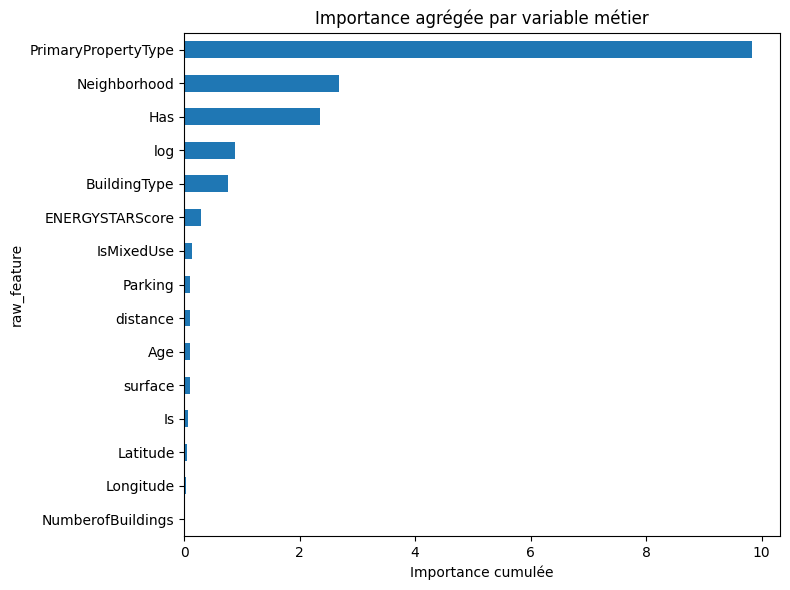

In [14]:
importance_df["raw_feature"] = (
    importance_df["feature"]
    .str.replace(r"^(num|cat)__", "", regex=True)
    .str.split("_")
    .str[0]
)

agg = (
    importance_df
    .groupby("raw_feature")["abs_coefficient"]
    .sum()
    .sort_values(ascending=False)
)

display(agg.head(15))


agg.head(15).sort_values().plot.barh(
    figsize=(8, 6),
    title="Importance agrégée par variable métier"
)
plt.xlabel("Importance cumulée")
plt.tight_layout()
plt.show()
